In [26]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn.metrics import r2_score
from datetime import datetime
import matplotlib.pyplot as plt

In [27]:
df_raw = pd.read_csv('covid_19_indonesia_time_series_all.csv')
df_raw.head()

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Longitude,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,3/1/2020,ID-JK,DKI Jakarta,2,0,0,2,489,20,39,...,106.836118,-6.204699,0.18,45.09,0.0,1.84,4.09%,7.98%,NaN,NaN
1,3/2/2020,ID-JK,DKI Jakarta,2,0,0,2,491,20,39,...,106.836118,-6.204699,0.18,45.27,0.0,1.84,4.07%,7.94%,1.0,1.0
2,3/2/2020,IDN,Indonesia,2,0,0,2,2,0,0,...,113.921327,-0.789275,0.01,0.01,0.0,0.00,0.00%,0.00%,NaN,NaN
3,3/2/2020,ID-JB,Jawa Barat,3,0,0,3,12,5,4,...,107.603708,-6.920432,0.07,0.27,0.0,0.11,41.67%,33.33%,NaN,NaN
4,3/3/2020,ID-JK,DKI Jakarta,2,0,0,2,493,20,39,...,106.836118,-6.204699,0.18,45.45,0.0,1.84,4.06%,7.91%,1.0,1.0


In [28]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7797 entries, 0 to 7796
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         7797 non-null   object 
 1   Location ISO Code            7797 non-null   object 
 2   Location                     7797 non-null   object 
 3   New Cases                    7797 non-null   int64  
 4   New Deaths                   7797 non-null   int64  
 5   New Recovered                7797 non-null   int64  
 6   New Active Cases             7797 non-null   int64  
 7   Total Cases                  7797 non-null   int64  
 8   Total Deaths                 7797 non-null   int64  
 9   Total Recovered              7797 non-null   int64  
 10  Total Active Cases           7797 non-null   int64  
 11  Location Level               7797 non-null   object 
 12  City or Regency              0 non-null      float64
 13  Province          

In [36]:
df_with_valuable_columns = df_raw.loc[:, ['Date', 'Location ISO Code', 'Total Cases']]
df_with_valuable_columns.head()

,Date,Location ISO Code,Total Cases
0,3/1/2020,ID-JK,489
1,3/2/2020,ID-JK,491
2,3/2/2020,IDN,2
3,3/2/2020,ID-JB,12
4,3/3/2020,ID-JK,493


In [37]:
df_idn = df_with_valuable_columns[df_with_valuable_columns['Location ISO Code'] == 'IDN'].reset_index()
df_idn.head()

,index,Date,Location ISO Code,Total Cases
0,2,3/2/2020,IDN,2
1,5,3/3/2020,IDN,2
2,8,3/4/2020,IDN,2
3,11,3/5/2020,IDN,2
4,15,3/6/2020,IDN,4


In [38]:
data = df_idn.loc[:, ['Date', 'Total Cases']]
data.head()

,Date,Total Cases
0,3/2/2020,2
1,3/3/2020,2
2,3/4/2020,2
3,3/5/2020,2
4,3/6/2020,4


In [46]:
# Referensi ->> https://www.wolframcloud.com/obj/covid-19/Published/Logistic-Growth-Model-for-COVID-19.nb
def logistic_model(x, k, t, L):
    return L/(1+np.exp(-k*(x-t)))
index_days = list(data.index)
total_cases_per_days = list(data.iloc[:, 1])
fit = curve_fit(logistic_model, index_days, total_cases_per_days)
A, B = fit
infection_speed_rate, day_peak, max_infected_people = A
errors = [np.sqrt(B[i][i]) for i in [0,1,2]]

day_end = int(fsolve(lambda x: logistic_model(x, infection_speed_rate, day_peak, max_infected_people) - int(max_infected_people), day_peak))
print(f'''infection_speed_rate: {infection_speed_rate},
std_err: {errors[0]}

day_peak: {day_peak},
std_err: {errors[1]}

max_infected_people: {max_infected_people},
std_err: {errors[2]}

day_end: {day_end}''')

infection_speed_rate: 0.022716709193064382,
std_err: 0.0002039333940335513

day_peak: 230.94101842310525,
std_err: 1.6535425731961313

max_infected_people: 726753.484894664,
std_err: 14206.522207303138

day_end: 856


In [42]:
cases_with_model = [logistic_model(case, infection_speed_rate, day_peak, max_infected_people) for case in index_days]
print(f'R-squared: {r2_score(data.iloc[:, 1], cases_with_model)}')

R-squared: 0.9988444255735739


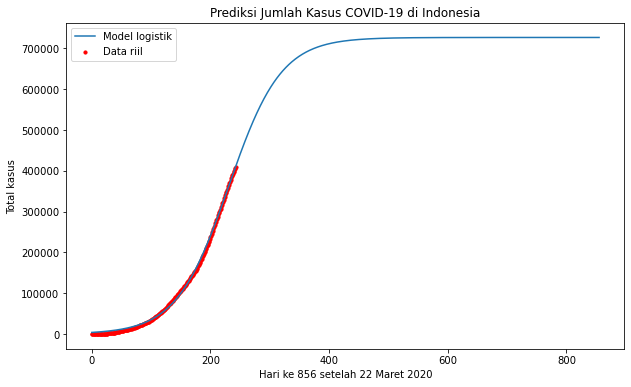

In [48]:
day_0 = pd.to_datetime('22/3/2020', format='%d/%m/%Y')
x_index = index_days + list(range(max(index_days), day_end))
plt.rcParams['figure.figsize'] = [10, 6]
# Data riil
plt.scatter(index_days, total_cases_per_days, label="Data riil", color="red", s=10)
# Model logistik
plt.plot(x_index, [int(logistic_model(i, infection_speed_rate, day_peak, max_infected_people)) for i in x_index], label="Model logistik" )
plt.legend()
plt.title('Prediksi Jumlah Kasus COVID-19 di Indonesia')
plt.ylabel('Total kasus')
plt.xlabel('Hari ke 856 setelah 22 Maret 2020')
plt.show()

In [47]:
day_peak_start_fmt = (day_0 + pd.Timedelta(days=int(day_peak - errors[1]))).strftime('%d %b %Y')
day_peak_end_fmt = (day_0 + pd.Timedelta(days=int(day_peak + errors[1]))).strftime('%d %b %Y')
day_end_fmt = (day_0 + pd.Timedelta(days=day_end)).strftime('%d %b %Y')

print(f'''Laju pertumbuhan tingkat penyebaran virus adalah {infection_speed_rate},
dengan standard error sebesar {errors[0]}.
    
Puncak pandemik diperkirakan terjadi sekitar {int(day_peak - errors[1])}-{int(day_peak + errors[1])} hari setelah 22 Mar 2020,
yaitu sekitar {day_peak_start_fmt} - {day_peak_end_fmt}.
Perlu dipahami bahwa puncak pandemik disini bukanlah pandemik sudah berakhir.
Puncak pandemik adalah hari dimana penambahan kasus per hari itu mencapai nilai maksimal.
Dengan kata lain, pertumbuhan kasus perhari setelah puncak pandemik akan mengalami penurunan.

Pandemik diperkirakan berakhir saat {day_end} hari setelah 22 Mar 2020, yaitu sekitar {day_end_fmt},
dengan total orang yang terinfeksi diperkirakan mencapai sekitar {int(max_infected_people - errors[2])}-{int(max_infected_people + errors[2])} orang.''')

Laju pertumbuhan tingkat penyebaran virus adalah 0.022716709193064382,
dengan standard error sebesar 0.0002039333940335513.
    
Puncak pandemik diperkirakan terjadi sekitar 229-232 hari setelah 22 Mar 2020,
yaitu sekitar 06 Nov 2020 - 09 Nov 2020.
Perlu dipahami bahwa puncak pandemik disini bukanlah pandemik sudah berakhir.
Puncak pandemik adalah hari dimana penambahan kasus per hari itu mencapai nilai maksimal.
Dengan kata lain, pertumbuhan kasus perhari setelah puncak pandemik akan mengalami penurunan.

Pandemik diperkirakan berakhir saat 856 hari setelah 22 Mar 2020, yaitu sekitar 26 Jul 2022,
dengan total orang yang terinfeksi diperkirakan mencapai sekitar 712546-740960 orang.
